In [1]:
# to avoid to restart kernel when external modules are modified
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import cv2
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append("../image_to_melody/")

from splitter import get_k_representatives

based on the article: https://betterprogramming.pub/making-music-from-images-with-python-81db627fd549

### READ IMAGE

In [3]:
base_path = "../sample_images"
sample_img_filename = "starry_night.jpg"
sample_img_filename = "earth.jpg"
#sample_img_filename = "turkey_nebula.jpg"
sample_img_filename = "girasol.jpeg"
sample_img_filename = "elon.jpeg"
sample_img_filename = "aurora.jpg"
sample_img_filename = "010_atardecer.jpg"

In [4]:
img = cv2.imread(filename=f"{base_path}/{sample_img_filename}")
color_image = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2HSV)

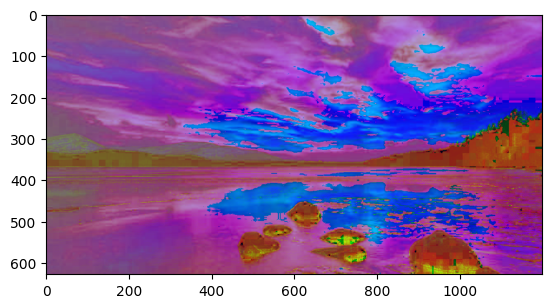

In [5]:
plt.imshow(hsv_img)
plt.show()

In [6]:
hsv_img.shape

(628, 1200, 3)

### Extract H, S, and V values from pixels

In [7]:
import random

import pandas as pd
import numpy as np

In [8]:
height, width, channels = hsv_img.shape
number_slices = 25
k = 5
# split the width in number_slices slices, and compute the K representative pixels
slice_width = width // number_slices

print("slice size", (height, slice_width))

slice size (628, 48)


In [9]:
# iterate over all the slices, computing for each one the K representative colors
# K / (height * slice_size) percent.
all_representative_pixels = list()
generate_proof_image = False
image_proof = Image.new("RGB", (width, height), (0, 0, 0))

for slice_i in range(0, width, slice_width):
    # iterate a single slice to get hsv values
    hsv_values = list()
    for x in range(slice_i, min(slice_i + slice_width, width)):
        for y in range(height):
            hsv_values.append(hsv_img[y][x])

    # compute the K representative pixels
    representatives = get_k_representatives(pixels=hsv_values, k=k)
    representatives = representatives.tolist()
    
    for representative in representatives:
        all_representative_pixels.append(representative)
    
    if not generate_proof_image:
        continue

    # build proof image
    for x in range(slice_i, min(slice_i + slice_width, width)):
        for y in range(height):
            idx = random.randint(0, len(representatives) - 1)
            random_repr_pixel = tuple(map(int, representatives[idx]))
            #random_repr_pixel = tuple(map(int, representatives[2]))

            image_proof.putpixel((x, y), value=random_repr_pixel)

In [11]:
image_proof.show()

In [10]:
df_repixels = pd.DataFrame(all_representative_pixels, columns=["hue", "saturation", "value"])
df_repixels.shape

(125, 3)

In OpenCV, the range of values are:
- HUE: 0-180
- SATURATION: 0-255
- VALUE: 0-255

In [11]:
print("HUE MAX", df_repixels["hue"].max())
print("SATURATION MAX", df_repixels["saturation"].max())
print("VALUE MAX", df_repixels["value"].max())

HUE MAX 174.6670188413466
SATURATION MAX 149.9012978142086
VALUE MAX 236.68545081967292


### Hues to frequencies

In [12]:
def hue_to_freq(hue_value: int, scale_freqs: list) -> float:
    """scale_freqs are the frequencies of the musical scale."""

    # those are the threshold of the hue value color.
    thresholds = [26 , 52, 78 , 104,  128, 154, 180]
    note = scale_freqs[0]

    for idx, threshold in enumerate(thresholds):
        if hue_value < threshold:
            note = scale_freqs[idx]
            break

    return note

**Select musical scale**

In [13]:
a_natural_minor_scale_freqs =  [220.00, 233.08, 261.63, 293.66, 311.13, 349.23, 392.00]
a_harmonic_minor_scale_freqs = [220.00, 246.94, 261.63, 293.66, 329.63, 349.23, 415.30]
a_major_scale_freqs =          [220.00, 246.94, 277.18, 293.66, 329.63, 370.00, 415.30]
# a_melodic_scale_freqs =        [220.00, 246.94, 277.18, 293.66, 329.63, 370.00, 415.30]
a_harmonic_major_scale_freqs = [220.00, 246.94, 261.63, 293.66, 329.63, 366.67, 440.00]


In [14]:
sample_percent = 0.15
total_pixels = int((width * height) * sample_percent)
r_acc, g_acc, b_acc = 0, 0, 0

for _ in range(total_pixels):
    x = random.randint(0, width - 1)
    y = random.randint(0, height - 1)
    pix = color_image[y][x]

    r_acc += pix[0]
    g_acc += pix[1]
    b_acc += pix[2]

avg_r = r_acc // total_pixels
avg_g = g_acc // total_pixels
avg_b = b_acc // total_pixels

In [15]:
scale_freq = []

if avg_r > 127 and avg_g > 127 and avg_b > 127:
    scale_freq = a_natural_minor_scale_freqs
elif avg_r > avg_g and avg_r > avg_b:
    scale_freq = a_harmonic_minor_scale_freqs
elif avg_b > avg_r and avg_b > avg_g:
    scale_freq = a_major_scale_freqs
else:
    scale_freq = a_harmonic_major_scale_freqs

print(scale_freq)

[220.0, 246.94, 261.63, 293.66, 329.63, 349.23, 415.3]


In [16]:
# add new column with the mapped frequency of the hue value
df_repixels["notes"] = df_repixels.apply(
    lambda row : hue_to_freq(row["hue"], scale_freq), axis=1
)     
df_repixels.head(10)

,hue,saturation,value,notes
0,120.695376,87.116500,41.016772,329.63
1,123.349736,85.869069,104.014436,329.63
2,117.492016,113.261790,92.882287,329.63
3,132.673854,75.972542,127.500220,349.23
4,128.720757,71.678499,159.061190,349.23
5,121.286861,86.563190,41.279338,329.63
6,122.361111,95.803045,92.309008,329.63
7,134.659866,73.844256,122.811700,349.23
8,128.013656,67.451433,160.795730,349.23
9,156.812027,81.066109,153.544405,415.30


### Saturation to Octaves

In [17]:
def saturation_to_octave(saturation_value: int, octave_values: list) -> float:
    # those are the threshold of the saturation value.
    thresholds = [60, 120, 180]
    assert len(octave_values) == len(thresholds)
    octave = octave_values[0]

    for idx, threshold in enumerate(thresholds):
        if saturation_value < threshold:
            octave = octave_values[idx]
            break

    return octave

In [18]:
# add column with the mapped octave value using the saturation value
octave_values = [0.5, 1, 2]

df_repixels["octave"] = df_repixels.apply(
    lambda row : saturation_to_octave(row["saturation"], octave_values), axis=1
)     
df_repixels.head(10)

,hue,saturation,value,notes,octave
0,120.695376,87.116500,41.016772,329.63,1.0
1,123.349736,85.869069,104.014436,329.63,1.0
2,117.492016,113.261790,92.882287,329.63,1.0
3,132.673854,75.972542,127.500220,349.23,1.0
4,128.720757,71.678499,159.061190,349.23,1.0
5,121.286861,86.563190,41.279338,329.63,1.0
6,122.361111,95.803045,92.309008,329.63,1.0
7,134.659866,73.844256,122.811700,349.23,1.0
8,128.013656,67.451433,160.795730,349.23,1.0
9,156.812027,81.066109,153.544405,415.30,1.0


### VALUES TO HARMONY


In [21]:
def value_to_harmony(value: int, harmonies: list) -> float:
    # sort armonies
    harmonies.sort()
    # generate equidistant thresholds
    thresholds = [threshold for threshold in range(0, 255, 255 // len(harmonies))]
    harmony_val = harmonies[-1]

    for i in range(1, len(thresholds)):
        if value < thresholds[i]:
            harmony_val = harmonies[i-1]
            break

    return harmony_val


In [22]:
# Harmony dictionary

harmony_selection = {
    "U0": 1,       # unison
    "ST": 16/15,   # semitone 
    "M2": 9/8,     # major second
    "m3": 6/5,     # minor third
    "M3": 5/4,     # major third
    "P4": 4/3,     # perfect fourth
    "DT": 45/32,   # diatonic tritone
    "P5": 3/2,     # perfect fifth
    "m6": 8/5,     # minor sixth
    "M6": 5/3,     # major sixth
    "m7": 9/5,     # minor seventh
    "M7": 15/8,    # major seventh
    "O8": 2,       # octave
}

In [23]:
harmonies = list(harmony_selection.values())

df_repixels["harmony"] = df_repixels.apply(
    lambda row : value_to_harmony(row["value"], harmonies), axis=1
)     
df_repixels.head(10)

,hue,saturation,value,notes,octave,harmony
0,115.000000,83.583333,34.000000,329.63,1.0,1.066667
1,112.927328,99.781983,23.145344,329.63,1.0,1.066667
2,77.500000,208.800000,76.400000,261.63,0.5,1.250000
3,77.000000,254.375000,75.125000,261.63,0.5,1.200000
4,73.000000,245.916667,122.625000,261.63,0.5,1.406250
5,114.985455,83.420000,34.340000,329.63,1.0,1.066667
6,112.913807,99.741421,23.172386,329.63,1.0,1.066667
7,83.000000,170.000000,42.000000,293.66,2.0,1.125000
8,76.701754,215.842105,85.368421,261.63,0.5,1.250000
9,77.000000,254.375000,75.125000,261.63,0.5,1.200000


### CHECK STATS

In [19]:
df_repixels.describe()

,hue,saturation,value,notes,octave
count,125.000000,125.000000,125.000000,125.00000,125.000000
mean,119.305568,73.678900,139.921564,341.64584,0.944000
std,58.456901,26.247871,63.886462,68.76367,0.331273
min,0.784200,9.516740,25.214342,220.00000,0.500000
25%,122.361111,61.125861,92.882287,329.63000,1.000000
50%,141.048840,72.681411,158.689708,349.23000,1.000000
75%,158.555468,90.828682,191.418611,415.30000,1.000000
max,174.667019,149.901298,236.685451,415.30000,2.000000


In [20]:
df_repixels.shape

(125, 5)

In [21]:
df_repixels["notes"].unique()

array([329.63, 349.23, 415.3 , 220.  ])

In [27]:
df_repixels["harmony"].unique()

array([1.06666667, 1.25      , 1.2       , 1.40625   , 1.125     ,
       2.        , 1.66666667, 1.5       , 1.8       , 1.875     ])

### Numpy frequencias array to playable audio

In [23]:
frequencies = df_repixels["notes"].to_numpy()
octaves = df_repixels["octave"].to_numpy()
#harmonies = df_repixels["harmony"].to_numpy()

In [24]:
# sample_rate = 22050 # sample rate
sample_rate = 44100 # 44.1 KHz - standard used in most CDs and digital audio formats
T = 0.23 # 0.1 second duration

# t represents an array of int(T*sample_rate) time values starting from 0 
# and ending at T, with a # fixed duration between each sample
t = np.linspace(0, T, int(T*sample_rate), endpoint=False) # time variable
t

array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       2.29931973e-01, 2.29954649e-01, 2.29977324e-01])

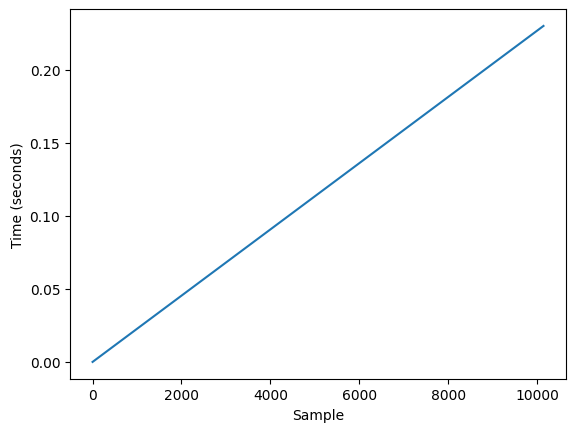

In [30]:
# Plot time variable
plt.plot(t)
plt.xlabel('Sample')
plt.ylabel('Time (seconds)')
plt.show()

In [25]:
import random

import IPython.display as ipd

In [35]:
from scipy.signal import square, sawtooth

In [38]:

song = np.array([])
use_armonony = False
# it's like a overlapped sound over the music.
harmony_sound = np.array([])

#Make a song with numpy array
#nPixels = int(len(frequencies))#All pixels in image
lim = int(len(frequencies))
num_pixels = lim
print("Num pixes of the sample", num_pixels)

for octave, freq in zip(octaves, frequencies):
    val = freq * octave
    # note  = 1.25 * np.sin(2*np.pi*val*t) # Represent each note as a sign wave
    note = 0.5 * sawtooth(2 * np.pi * val * t)
    song  = np.concatenate([song, note]) # Add notes into song array to make song
    # harmony
    # h_note = 0.5 * np.sin(2*np.pi*harmony*val*t)
    if use_armonony:
        pass
        # harmony_sound = np.concatenate([harmony_sound, h_note])


# for i in range(num_pixels):  
#     freq = frequencies[i]
#     # idx = random.randint(0, lim)
#     # freq = frequencies[idx]
#     note  = 0.5*np.sin(2*np.pi*freq*t) # Represent each note as a sign wave
#     song  = np.concatenate([song, note]) # Add notes into song array to make song


Num pixes of the sample 125


In [28]:
ipd.Audio(data=song, rate=sample_rate, autoplay=True) # load a NumPy array as audio

### Save audio


In [29]:
from scipy.io import wavfile

In [39]:
audio_filename = sample_img_filename.split(".")[0]

# final_song = np.vstack((song, harmony_sound)).T if use_armonony else song

wavfile.write( 
    f"../output_music/{audio_filename}.wav",
    rate=sample_rate,
    data=song.astype(np.float32)
)

## Trying Pedalboard

In [93]:
from pedalboard import (
    Pedalboard,
    Chorus,
    LadderFilter,
    Gain,
    Reverb,
    Delay,
    Phaser,
    Compressor,
    Limiter,
    HighpassFilter
)
from pedalboard.io import AudioFile

In [104]:
# Make a Pedalboard object, containing multiple audio plugins:
board = Pedalboard([
    HighpassFilter(),
    Compressor(threshold_db=0, ratio=25),
])

In [105]:
BASE_AUDIO_PATH = "../output_music"

audio_examples = [
    f"{BASE_AUDIO_PATH}/exp_0/005_epic_Jordan.wav",
    f"{BASE_AUDIO_PATH}/exp_1/005_epic_Jordan.wav",
    f"{BASE_AUDIO_PATH}/exp_0/008_flowers_field.wav",
    f"{BASE_AUDIO_PATH}/exp_1/008_flowers_field.wav",
]

In [106]:
for audio_example_path in audio_examples:
    with AudioFile(audio_example_path) as f:
        new_path = audio_example_path.replace(".wav", "_effected.wav")
        with AudioFile(new_path, "w", f.samplerate, f.num_channels) as o:
            # Read one second of audio at a time, until the file is empty:
            while f.tell() < f.frames:
                chunk = f.read(int(f.samplerate))

                # Run the audio through our pedalboard:
                effected = board(chunk, f.samplerate, reset=False)

                # Write the output to our output file:
                o.write(effected)